ДЗ должна быть выполнена строго на torch
1 - использовать dataloader. 
2 - в цикл обучения добавить сохранения лучшей модели / шедулер для скорости обучения. 
3 - вывести графики обучения. Выводить информацию по обучению в процессе. 

Решить задачу предсказания возраста. Свести к задаче классификации. 
0- 9 10 -19 - 20 -29 30 -39 40 49 50 59 ...
 
В качестве фьючеэкстрактора используйте любую вариацию vit. ** - 

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
#!pip install tf-keras
#!pip install transformers
#!pip install huggingface_hub[hf_xet]
!pip install torchinfo


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
import pandas as pd
import keras as tf
import os
import re
from torchinfo import summary

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from transformers import AutoModelForImageClassification, AutoTokenizer, AutoConfig
#from transformers import Trainer, TrainingArguments
from PIL import Image

ImageFile.LOAD_TRUNCATED_IMAGES=True
torch.__version__
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [2]:
pict_dir = "./pict_more_60_pixel"
correct_files = 0
filepath = []
labels = []
dataset_lenth = 35000
uncorrect_files = 0
files = os.listdir(pict_dir)

# Функция для определения возрастной группы
def get_age_group(age):
    if age < 10:
        return 0  # 
    elif age < 20:
        return 1  # 
    elif age < 30:
        return 2  # 
    elif age < 40:
        return 3  # 
    elif age < 50:
        return 4  # 
    elif age < 60:
        return 5  # 
    elif age < 70:
        return 6  # 
    elif age < 80:
        return 7  # 
    elif age < 90:
        return 8  #    
    else:
        return 9  # 


# Кастомный Dataset
class AgeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        correct_files = 0
        uncorrect_files = 0

        for pict in os.listdir(data_path):
            try:        
                year_of_card = os.path.basename(pict)[-8:-4]
                birth  = os.path.basename(pict)[-19:-15]  
                age =   int(year_of_card)-int(birth)
                if (age>3 and age<105):
                    self.labels.append(get_age_group(int(year_of_card)-int(birth)))
                    self.images.append(self.data_path+"/"+pict)    
                    correct_files+=1                            
            except Exception as e:
                uncorrect_files+=1
                print(f"Ошибка обработки файла {pict}: {e}")
                
        if len(filepath)==len(labels):
            print("Датасет корректен",len(filepath))
        else:
            print("Датасет некорректен, разные длины массивов меток и данны!!!!!!!!!!!!!!! ")   
        
        print("Некорректных файлов",uncorrect_files)
        print("Корректных файлов",correct_files)
               

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])#.convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label





Приведем примеры изображений с классами возраста:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow 

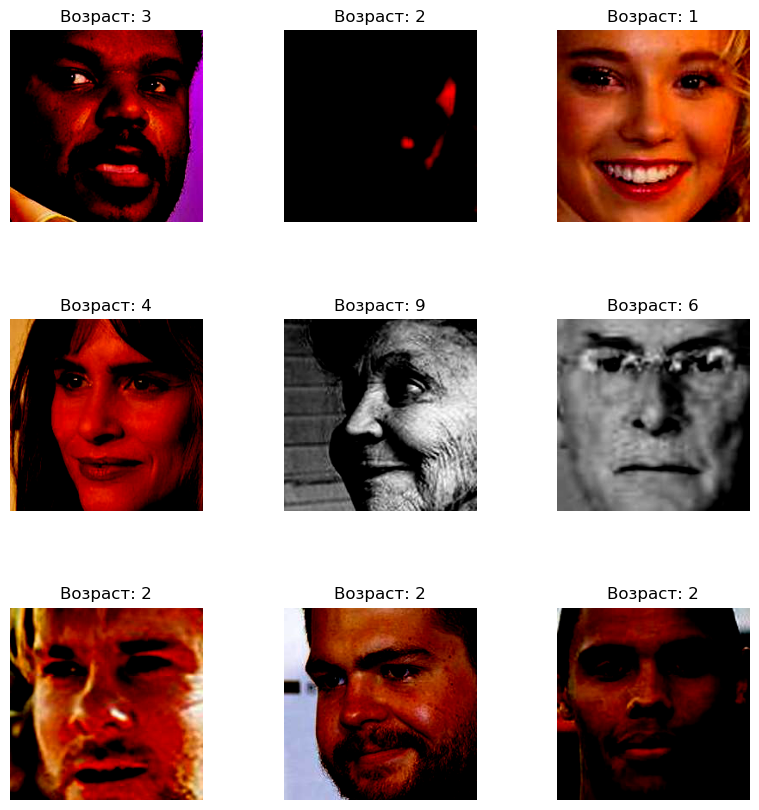

In [5]:
import matplotlib.pyplot as plt
import random


# Создание таблицы 3x3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    rnd_num = random.randrange(0, dataset.__len__())
    #path = data_set.iat[rnd_num,0]
    #label = data_set.iat[rnd_num,1]
    ax.imshow((dataset.__getitem__(rnd_num)[0]).permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"Возраст: {dataset.__getitem__(rnd_num)[1]}")

plt.show()

In [ ]:
import accelerate
# Путь к папке с изображениями
data_path = "./pict_more_60_pixel"

transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    #transforms.RandomResizedCrop(size=(64, 64), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Загрузка датасета
dataset = AgeDataset(data_path, transform=transform)

Ошибка обработки файла 32339345_1994-11-18._2015.jpg: invalid literal for int() with base 10: '994-'
Ошибка обработки файла 5139000_1963-02-006_2009.jpg: invalid literal for int() with base 10: '963-'
Ошибка обработки файла 706798_1989-08-019_2009.jpg: invalid literal for int() with base 10: '989-'
Датасет корректен 0
Некорректных файлов 3
Корректных файлов 34349


In [ ]:
num_epoch = 5
# Разделение на train, val, test
train_size = int(0.7 * dataset.__len__())
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print("train dataset:",len(train_dataset),"val dataset: ",len(val_dataset),"test dataset: ",len(val_dataset))
# DataLoader для загрузки данных
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=3)


model_name = "google/vit-base-patch16-224"
#model_name = "OpenGVLab/pvt_v2_b0"
#model_name = "WinKawaks/vit-tiny-patch16-224"

config = AutoConfig.from_pretrained(model_name)#, num_labels=10)  # Количество возрастных групп
model = AutoModelForImageClassification.from_pretrained(model_name, config=config)
sample = torch.randn(1,3,224,224)


# Замораживание всех слоев, кроме последних
for param in model.parameters():
    param.requires_grad = False
for param in list(model.parameters())[-10:]:  # Размораживаем последние 10 параметров 
    param.requires_grad = True

face_classifier = nn.Sequential(
    nn.Linear(model.config.hidden_size, 128),
    nn.ReLU(),
    nn.Linear(128, 10)  
)

# Замена оригинального классификатора
model.classifier = face_classifier

print(model)
summary(model, input_size=(1,3,224,224))

train dataset: 24044 val dataset:  5152 test dataset:  5152
ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featu

Layer (type:depth-idx)                                  Output Shape              Param #
ViTForImageClassification                               [1, 10]                   --
├─ViTModel: 1-1                                         [1, 197, 768]             --
│    └─ViTEmbeddings: 2-1                               [1, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [1, 196, 768]             (590,592)
│    │    └─Dropout: 3-2                                [1, 197, 768]             --
│    └─ViTEncoder: 2-2                                  [1, 197, 768]             --
│    │    └─ModuleList: 3-3                             --                        85,054,464
│    └─LayerNorm: 2-3                                   [1, 197, 768]             1,536
├─Sequential: 1-2                                       [1, 10]                   --
│    └─Linear: 2-4                                      [1, 128]                  98,432
│    └─ReLU: 2-5                 

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cuda:0"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        batch_num = 0
        for batch in train_loader:
            print("batch_number:  ",batch_num)
            batch_num+=1
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)#.half()
            targets = targets.to(device)#.half()
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)
   
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)#.half()
            output = model(inputs)#.half()
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)          
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
    
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5)



cuda


Выводы. На малых моделях обучение происходило. Н vit моделях даже одна эпоха идет более нескольких часов. Т.е не успел выполнить обучение.